# Lab 8: GANs

### Description
In this lab, we will build our very first GAN. This can be frustrating at first, but the end result is really cool. We've tried to make the steps intuitive.

Here is what you will learn:
* GANs are generative models that learn to generate data, based on a min-max/adversarial game between a Generator (G) and Discriminator (D).
* The parameters of both Generator and Discriminator are optimized with Stochastic Gradient Descent (SGD) or RMSprop or Adam
* How these concepts translate into PyTorch code for GAN optimization.

Overview of the tutorial:
1. GAN intro
2. Defining the neural networks in PyTorch, computing a forward pass
3. Training our GAN

This lab is modified from https://github.com/tomsercu/gan-tutorial-pytorch

Full notebook: https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/2019-04-23%20GAN%20Tutorial%20with%20outputs.ipynb

### Deliverable
We have provided the GAN architecture for you. Your objective is to:
1. Create a DataLoader for the CelebA dataset.
2. Create a Dataset and a DataLoader for a dataset from a domain of your choice.
3. Implement the original GAN loss
4. Implement the training loop and train your GAN.

### Grading Standards
- 25% correctly implement the original GAN loss
- 25% correctly implement the training loop 
- 25% Train on CelebA and display results
- 25% Train on your own dataset and display results

(you will not be graded on quality of generated images)


### Tips:
- This lab is complex. Please read through the entire spec before diving in.
- Also, note that training on this dataset will likely take some time. Please make sure you start early enough to run the training long enough!
- Expected values: Discriminator Loss will hover around ~ 0.5, Generator Loss should hover around ~ 5.5. You should see discernible results within 1 epoch (~20-30 minutes of training on Colab).

# Some cool demos:
* Progress over the last 5 years, from [Ian Goodfellow tweet](https://twitter.com/goodfellow_ian/status/1084973596236144640)

![tweet image](https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/figs/goodfellow_tweet.jpg?raw=1)

* CycleGAN translating horses into zebras: https://www.youtube.com/watch?v=9reHvktowLY
* CycleGAN teaser: ![cyclegan teaser image](https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/figs/cyclegan_teaser_high_res.jpg?raw=1)
* High resolution faces with StyleGAN https://www.youtube.com/watch?v=kSLJriaOumA
* https://ganbreeder.app web-interface to create images based on [BigGan](https://arxiv.org/abs/1809.11096)


# 1. GAN first introduction
[GAN picture](figs/gan_xavigiro.png)

<img src="https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/figs/gan_xavigiro.png?raw=1" alt="GAN picture" style="width: 700px;"/>

GANs are a class of unsupervised generative models which implicitly model the data density.

The basic setup is pictured above. There are two "competing" neural networks:
* The Generator wants to learn to generate realistic images that are indistinguishable from the real data. 
    - *input*: Gaussian noise random sample. *output*: a (higher dimensional) datapoint
* The Discriminator wants to tell the real & fake images apart.
    - *input*: datapoint/image, *output*: probability assigned to datapoint being real. Think binary classifier.
* The typical analogy: the generator is like a counterfeiter trying to look like real, the discriminator is the police trying to tell counterfeits from the real work.
* The key novelty of GANs is to pass the error signal (gradients) from the discriminator to the generator: the generator neural network uses the information from the competing discriminator neural network to know how to produce more realistic output.

Let's start with defining the generator G and discriminator D in pytorch.

# 2. Define the Generator and Discriminator

In [1]:
import sys
# print(sys.version)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# enable interactivity by running magic command: %matplotlib notebook
# Note: this must occur BEFORE importing matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os, time

# For creating progress bars
from tqdm.notebook import tqdm


# Set the default device for PyTorch (cpu or gpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device.type}')

# You can use whatever display function you want. This is a really simple one that makes decent visualizations
def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

Device used: cuda


In [2]:
if device.type == 'cuda':
    !nvidia-smi

Fri Mar  4 23:14:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    31W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Defining the neural networks

In [3]:
class Generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # forward method
    def forward(self, x):
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

In [4]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

In [5]:
#####
# instantiate a Generator and Discriminator according to their class definition.
#####

G = Generator()
D = Discriminator()

print(G)
print(D)

Generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(

## Testing the neural networks (forward pass)

In [6]:
# batch size x channels x height x width, see: https://pytorch.org/vision/0.8/transforms.html
samples = torch.randn(5, 3, 64, 64)
print(f'Samples: {samples.shape}\nOutput: {D(samples).shape}\n')

# samples = torch.randn(5, 3, 50, 82)
# print(f'Samples: {samples.shape}\nOutput: {D(samples).shape}\n')

samples = torch.randn(5, 3, 128, 128)
print(f'Samples: {samples.shape}\nOutput: {D(samples).shape}\n')

samples = torch.randn(5, 3, 156, 256)
print(f'Samples: {samples.shape}\nOutput: {D(samples).shape}')

# Note: if you change the conv layers in D to stride=1 (instead of 2),
# the code cell takes 80x longer to run (80s vs 1s) and produces output
# dimensions that are 7 less than the inputs, so 64x64 becomes 57x57

Samples: torch.Size([5, 3, 64, 64])
Output: torch.Size([5, 1, 1, 1])

Samples: torch.Size([5, 3, 128, 128])
Output: torch.Size([5, 1, 5, 5])

Samples: torch.Size([5, 3, 156, 256])
Output: torch.Size([5, 1, 6, 13])


Things to try:
* What happens if you change the number of samples in a batch?
* What happens if you change the width/height of the input?
* What are the weights of the discriminator? You can get an iterator over them with `.parameters()` and `.named_parameters()`

In [7]:
print(f'Generator: {sum([param.numel() for param in G.parameters()]):,d}')
print(f'Discriminator: {sum([param.numel() for param in G.parameters()]):,d}')

Generator: 12,660,355
Discriminator: 12,660,355


In [8]:
for name, p in D.named_parameters():
    print(name, p.shape)

conv1.weight torch.Size([128, 3, 4, 4])
conv1.bias torch.Size([128])
conv2.weight torch.Size([256, 128, 4, 4])
conv2.bias torch.Size([256])
conv2_bn.weight torch.Size([256])
conv2_bn.bias torch.Size([256])
conv3.weight torch.Size([512, 256, 4, 4])
conv3.bias torch.Size([512])
conv3_bn.weight torch.Size([512])
conv3_bn.bias torch.Size([512])
conv4.weight torch.Size([1024, 512, 4, 4])
conv4.bias torch.Size([1024])
conv4_bn.weight torch.Size([1024])
conv4_bn.bias torch.Size([1024])
conv5.weight torch.Size([1, 1024, 4, 4])
conv5.bias torch.Size([1])


We will think of the concatentation of all these discriminator weights in one big vector as $\theta_D$.

Similarly we name the concatentation of all the generator weights in one big vector $\theta_G$.

In [9]:
for name, p in G.named_parameters():
    print(name, p.shape)

deconv1.weight torch.Size([100, 1024, 4, 4])
deconv1.bias torch.Size([1024])
deconv1_bn.weight torch.Size([1024])
deconv1_bn.bias torch.Size([1024])
deconv2.weight torch.Size([1024, 512, 4, 4])
deconv2.bias torch.Size([512])
deconv2_bn.weight torch.Size([512])
deconv2_bn.bias torch.Size([512])
deconv3.weight torch.Size([512, 256, 4, 4])
deconv3.bias torch.Size([256])
deconv3_bn.weight torch.Size([256])
deconv3_bn.bias torch.Size([256])
deconv4.weight torch.Size([256, 128, 4, 4])
deconv4.bias torch.Size([128])
deconv4_bn.weight torch.Size([128])
deconv4_bn.bias torch.Size([128])
deconv5.weight torch.Size([128, 3, 4, 4])
deconv5.bias torch.Size([3])


In [10]:
# A small batch of 2 samples, random noise.
z = torch.randn(2, 100).view(-1,100,1,1)
x_gen = G(z)
# notice that the generated value is a batch of 2 images
x_gen.shape

torch.Size([2, 3, 64, 64])

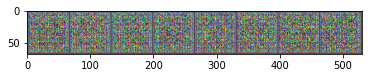

In [11]:
z = torch.randn(8, 100).view(-1,100,1,1).to(device)
G = G.to(device)
show_imgs(G(z))

In traditional deep learning, you measure performance by looking at the loss value. In GANs, this does not work well because we are performing a Min-Max and the loss values may not be intuitively lower when the network is doing well. 

So, performance must be measured qualitatively, by looking at images. Therefore, you can sample random $z$ vectors every pass through the network to see how "novel" the generation is becoming. And you can also sample a single $z$ vector that is passed through the network every time to see how a single example progresses during training. 

In [6]:
fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1)    # fixed noise
fixed_z_ = fixed_z_.to(device)

## Loading the data and computing forward pass

## CelebA dataset

In [ ]:
# download the data, and change the filepath
if not os.path.exists('./celeba.zip'):
    # See: https://adamtheautomator.com/python-wget/
    !wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

!unzip /content/celeba -d celebA

### Create dataset and dataloader

In [14]:
batch_size = 128
img_size = 64

# possible sources for celeba: this AWS link: https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
celeba_dataset = torchvision.datasets.ImageFolder(root='./celebA',
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

##### Create the DataLoader #####
celeba_train_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=True)

Dataset and DataLoader are abstractions to help us iterate over the data in random order.

Let's look at a sample:

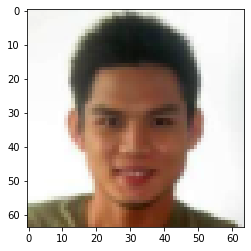

In [15]:
ix=64
x, _ = celeba_dataset[ix]
show_imgs(x)

Feed the image into the discriminator; the output will be the probability the (untrained) discriminator assigns to this sample being real.

In [16]:
# for one image:
Dscore = D(x.unsqueeze(0))
print(f'Probability that the image is real: {Dscore.item():.2%}')

Probability that the image is real: 42.53%


In [17]:
# How you can get a batch of images from the dataloader:
xbatch, _ = iter(celeba_train_loader).next()
xbatch.shape
D(xbatch)
D(xbatch).shape

torch.Size([128, 1, 1, 1])

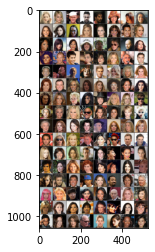

In [18]:
show_imgs(xbatch)

# 3. Now to train your GAN

We introduced and defined the generator G, the discriminator D, and the dataloader which will give us minibatches of real data. 

To recap the basic idea of the min-max / adversarial game:
* The Generator and Discriminator have competing objectives, they are "adversaries".
* The Discriminator wants to assign high probability to real images and low probability to generated (fake) images
* The Generator wants its generated images to look real, so wants to modify its outputs to get high scores from the Discriminator
* We will optimize both alternatingly, with SGD steps (as before): optimize $\theta_D$ the weights of $D(x, \theta_D)$, and  $\theta_G$ the weights of $G(z, \theta_G)$.
* Final goal of the whole min-max game is for the Generator to match the data distribution: $p_G(x) \approx p_{data}(x)$.


Now what are the objective functions for each of them? As mentioned in the introduction, the objective for the discriminator is to classify the real images as real, so $D(x) = 1$, and the fake images as fake, so $D(G(z))=0$.
This is a typical binary classification problem which calls for the binary cross-entropy (BCE) loss, which encourages exactly this solution.

For G we just try to minimize the same loss that D maximizes. See how G appears inside D? This shows how the output of the generator G is passed into the Discriminator to compute the loss.


This is the optimization problem:

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text { data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$

We will do a single SGD step alternatingly to maximize D, then minimize G.
In fact for G we use a modified (non-saturing) loss $-\log D(G(z))$. Different modifications of the loss and the relation to the distance between distributions $p_{data}$ and $p_{G}$ became a topic of research over the last years.

BCE takes care of the log, you won't manually compute any Log values


In [7]:
def train(train_loader):
    num_iter = 0
    
    for epoch in range(train_epoch):
        D_losses = []
        G_losses = []
        epoch_start_time = time.time()
        for x_, _ in tqdm(train_loader):
            # train discriminator D
            D.zero_grad()

            mini_batch = x_.size()[0]

            #####
            # create y_real_ and y_fake_ tensors you will use in your BCE loss
            # to push probabilities in the proper direction.
            # y_real_ will be a tensor of all ones to provide labels to the
            # discriminator for batches of real images
            # y_fake_ will be a tensor of all zeros to provide labels to the
            # discriminator for generated (fake) images
            #####

            # Dimensions: batch_size, labels
            y_real_ = torch.ones(mini_batch, 1)
            y_fake_ = torch.zeros(mini_batch, 1)

            x_, y_real_, y_fake_ = x_.to(device), y_real_.to(device), y_fake_.to(device)

            #####
            # pass x_ through the discriminator to get D_result
            # you will need to squeeze() the output before passing it to BCE_loss
            # compute D_real_loss using BCE_loss and the proper y tensor from above
            # you are trying to make the discriminator recognize the real image properly
            #####
            D_result = D(x_)
            D_real_loss = BCE_loss(D_result.view(mini_batch, 1), y_real_)

            #####
            # sample a z vector (remember to view(-1,100,1,1))
            # pass the z vector to the GPU and through your generator
            # this will create G_result
            #####
            z = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).to(device)
            # Detach from computation graph to save computation
            G_result = G(z).detach()

            #####
            # pass G_result through the discriminator and get D_result
            # you will need to squeeze() the output of the discriminator
            # compute D_fake_loss for the generated images by using BCE_loss and the proper y_tensor
            # you are trying to make the discriminator recognize the fake image properly
            #####
            D_result = D(G_result)
            D_fake_loss = BCE_loss(D_result.view(mini_batch, 1), y_fake_)

            #####
            # sum D_real_loss and D_fake_loss to get D_train_loss
            # compute the gradients
            # step the optimizer
            #####
            D_train_loss = D_real_loss + D_fake_loss
            D_train_loss.backward()
            D_optimizer.step()

            D_losses.append(D_train_loss.item())

            # train generator G
            G.zero_grad()

            #####
            # sample a z vector (viewed properly) and pass it to the GPU and through the generator
            # compute the discriminated value of the generated image, properly squeezing the output
            # get G_train_loss by using BCE_loss and the proper y_tensor
            # you are trying to make the generator generate real images
            # compute the gradients
            # step the optimizer
            #####
            z = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).to(device)
            G_result = G(z)
            D_result = D(G_result)
            G_train_loss = BCE_loss(D_result.view(mini_batch, 1), y_real_)
            G_train_loss.backward()
            G_optimizer.step()

            G_losses.append(G_train_loss.item())
            num_iter += 1

        # generate a fixed_z_ image and save
        x_gen = G(fixed_z_)
        collect_x_gen.append(x_gen.detach().clone())
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        # print out statistics
        print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                                  torch.mean(torch.FloatTensor(G_losses))))
        
        show_imgs(G_result[:4])

  0%|          | 0/1583 [00:00<?, ?it/s]

  0%|          | 0/1583 [00:00<?, ?it/s]

  0%|          | 0/1583 [00:00<?, ?it/s]

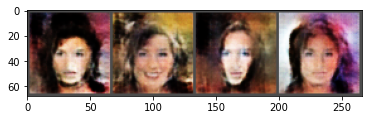

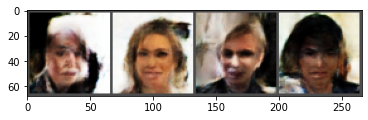

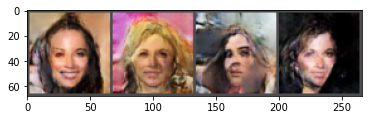

In [25]:
G = Generator(128)
D = Discriminator(128)
G = G.to(device)
D = D.to(device)

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Set learning rate
lr = 0.0002

# Set number of epochs to train for
train_epoch = 3

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
# Train GAN
collect_x_gen = []
train(celeba_train_loader)

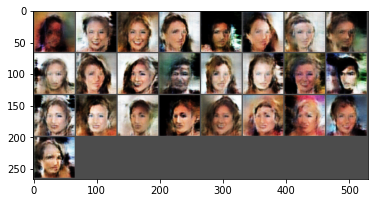

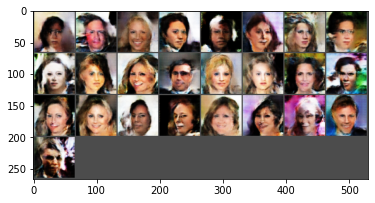

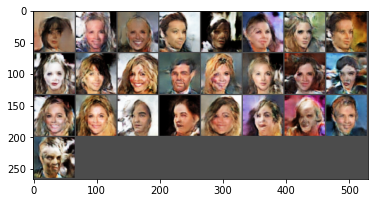

In [26]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

Now generate something with your own dataset! (Fashion, Mnist, Coco, Bedrooms, Pokemon)

## Custom dataset (vehicles)

I use a custom image dataset I scraped from CarAndDriver.com (after reviewing the site's [robots.txt](https://www.caranddriver.com/robots.txt) page, which allows algorithmic access to the content I selected).

**Source: CarAndDriver.com**

vehicle_specs.csv (650 images)

https://raw.githubusercontent.com/rparkr/ML-practice/main/Vehicle%20specs/Final%20project/vehicle_specs.csv

### Other image datasets
**CelebA dataset**
* [Main site](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
* Direct download (aligned and cropped images): https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg&usp=sharing


**Vehicle images from CarAndDriver.com**
* vehicle_models.csv (775 images): https://raw.githubusercontent.com/rparkr/ML-practice/main/Vehicle%20specs/Final%20project/vehicle_models.csv
* vehicle_specs.csv (650 images): https://raw.githubusercontent.com/rparkr/ML-practice/main/Vehicle%20specs/Final%20project/vehicle_specs.csv
* vehicle_specs_final.csv (521 images): https://raw.githubusercontent.com/rparkr/ML-practice/main/Vehicle%20specs/Final%20project/vehicle_specs_final.csv


**Other interesting image sets (NASA)**
* https://images.nasa.gov/
* Hubble (great for web scraping!): https://www.nasa.gov/mission_pages/hubble/multimedia/index.html
* Galleries: https://www.nasa.gov/multimedia/imagegallery/index.html
* Earth from space: https://earthobservatory.nasa.gov/images

In [2]:
import pandas as pd             # store and analyze tabular data (like .csv files)
import requests                 # access and download web content
import os                       # manage directories
from tqdm.notebook import tqdm  # create progress bars
import time                     # pause code execution

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/rparkr/ML-practice/main/Vehicle%20specs/Final%20project/vehicle_specs.csv')

# Keep only the columns needed: Year, Make, Model, and Image URL
df = df[['Year', 'Make', 'Model', 'Image']].dropna()

df.head()
# Create a list of the vehicle names in the format: year_make_model.jpg (e.g., 2021_Honda_Civic)
file_names = []
for n, year, make, model, image_url in df.itertuples():
    # Capture the final 4 characters of the URL (the image type)
    filetype_start = image_url.rfind('.')
    filetype = image_url[filetype_start:]
    # Name the file: year_make_model.jpg
    filename = f"{year}_{make.replace('/', '-')}_{model.replace('/', '-')}{filetype}"
    filename = filename.replace(' ', '-')
    file_names.append(filename)

# Create a list of the images
image_urls = df['Image'].values.tolist()
print(f'Number of images: {len(image_urls)}')
print('Examples:', file_names[:3])

Number of images: 649
Examples: ['2022_Acura_MDX.jpg', '2022_Acura_ILX.jpg', '2022_Acura_NSX-Type-S.jpg']


In [10]:
# Save images to a folder
# =======================

# Create folder if it does not already exist
if not os.path.exists('./vehicles'):
    os.mkdir('./vehicles')

progress = tqdm(total=len(image_urls))
# Download and save images to the folder
for n, img_url in enumerate(image_urls):
    # Download image (binary file)
    img_to_save = requests.get(img_url).content
    filename = file_names[n]
    # Save image
    with open(f'./vehicles/{filename}', mode='wb') as img_file:
        img_file.write(img_to_save)
    progress.update(n=1)
    # Pause for 10 milliseconds, as requested by CarAndDriver.com/robots.txt
    time.sleep(0.01)

  0%|          | 0/774 [00:00<?, ?it/s]

In [51]:
# Save all files in a single, compressed .zip archive
# See: https://www.kite.com/python/examples/4930/zipfile-compress-all-files-in-a-directory-into-a-zip-file
# Also: https://www.kite.com/python/examples/3416/zipfile-compress-files-into-a-zip-file

import zipfile
pbar = tqdm(total=len(os.listdir('./vehicles')))

# note: no compression is used. zipfile.ZIP_DEFLATED 
# compressed the files by only about 1%, so I am leaving them uncompressed.
with zipfile.ZipFile('vehicles.zip', 'w') as zf:
    for one_file in os.listdir('vehicles/'):
        zf.write(f'vehicles/{one_file}')
        pbar.update(n=1)

print('Successfully zipped files into folder: vehicles.zip')

  0%|          | 0/774 [00:00<?, ?it/s]

Successfully zipped files into folder: vehicles.zip


In [52]:
print(f"vehicles.zip folder size: {os.stat('vehicles.zip').st_size:,d} bytes")

vehicles.zip folder size: 1,051,307,841 bytes


### Dataset class

References
* https://github.com/utkuozbulak/pytorch-custom-dataset-examples
* https://pytorch.org/vision/stable/datasets.html
* https://pytorch.org/docs/stable/data.html

Note on transforms

The images have the aspect ratio (800/489 = 1.635), which is downsized to have a similar number of pixels to a 64x64 image and becomes 82x50 (1.64 aspect ratio). A 64x64 image has 4,096 pixels, and an 82x50 image has 4,100 pixels.

An image size of 105w x 64h has an aspect ratio of 1.641 and 6,720 pixels. The benefit is that the smallest dimension is 64, which works with the discriminator in its current configuration.

In [55]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class vehicle_dataset(Dataset):
    def __init__(self, path_to_folder, file_list):
        # No need to inherit from the base class (torch.utils.data.Dataset)
        # That is, we don't need: super().__init__()
        self.folder_path = path_to_folder
        self.files = file_list
        # self.resize = transforms.Resize(size=(64, 105))
        self.resize = transforms.Resize(size=(74, 121))
        self.centercrop = transforms.CenterCrop(64)
        self.totensor = transforms.ToTensor()

    def __getitem__(self, index):
        img = Image.open(self.folder_path + self.files[index])
        # Use PIL to convert to RGB (in case the image is RGBA)
        # See: https://pillow.readthedocs.io/en/latest/handbook/concepts.html#modes
        # And: https://www.kite.com/python/answers/how-to-convert-a-rgba-image-to-a-rgb-image-with-pil-in-python
        if img.mode == 'RGBA':
            img = img.convert(mode='RGB')
        # Perform transforms
        img = self.resize(img)
        img = self.centercrop(img)
        img_as_tensor = self.totensor(img)
        # All images are real, thus, all have label 1
        label = 1
        return img_as_tensor, label
    
    def __len__(self):
        return len(self.files)

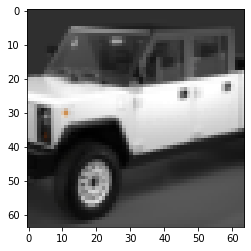

In [64]:
custom_dataset = vehicle_dataset('/content/vehicles/', file_names)
x, _ = custom_dataset[122]
show_imgs(x)

## Training: custom dataset

In [61]:
# Create a Dataloader for your own dataset
batch_size = 64
your_train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (151301008 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (134497676 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (94783876 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[1/10] - ptime: 257.01, loss_d: 0.614, loss_g: 14.700


  0%|          | 0/13 [00:00<?, ?it/s]

[2/10] - ptime: 255.15, loss_d: 0.711, loss_g: 19.749


  0%|          | 0/13 [00:00<?, ?it/s]

[3/10] - ptime: 248.53, loss_d: 0.206, loss_g: 19.386


  0%|          | 0/13 [00:00<?, ?it/s]

[4/10] - ptime: 247.86, loss_d: 0.388, loss_g: 19.880


  0%|          | 0/13 [00:00<?, ?it/s]

[5/10] - ptime: 249.33, loss_d: 0.161, loss_g: 8.843


  0%|          | 0/13 [00:00<?, ?it/s]

[6/10] - ptime: 247.22, loss_d: 0.687, loss_g: 7.373


  0%|          | 0/13 [00:00<?, ?it/s]

[7/10] - ptime: 249.58, loss_d: 0.682, loss_g: 5.275


  0%|          | 0/13 [00:00<?, ?it/s]

[8/10] - ptime: 252.23, loss_d: 0.973, loss_g: 3.658


  0%|          | 0/13 [00:00<?, ?it/s]

[9/10] - ptime: 255.53, loss_d: 1.020, loss_g: 2.258


  0%|          | 0/13 [00:00<?, ?it/s]

[10/10] - ptime: 257.52, loss_d: 1.231, loss_g: 1.876


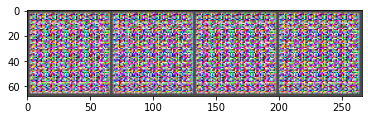

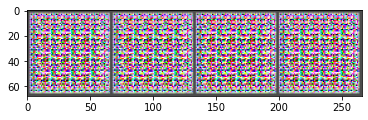

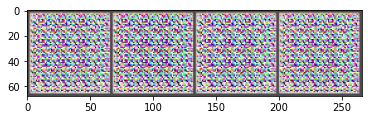

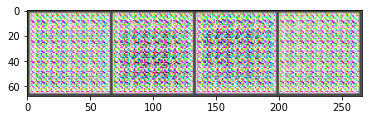

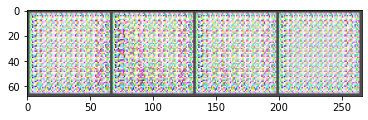

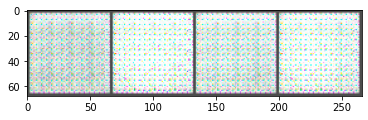

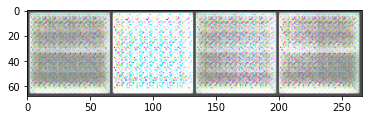

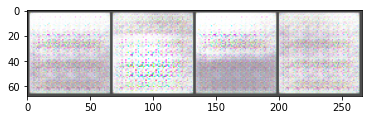

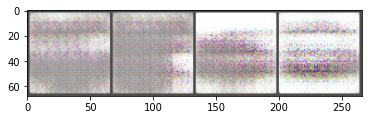

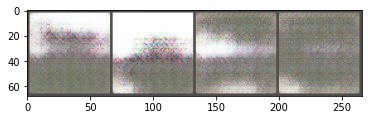

In [59]:
G = Generator(128)
D = Discriminator(128)
G = G.to(device)
D = D.to(device)

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Set learning rate
lr = 0.0002

# Set number of epochs to train for
train_epoch = 10

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
# Train GAN
collect_x_gen = []
train(your_train_loader)

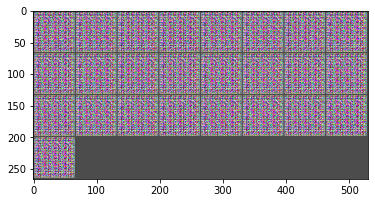

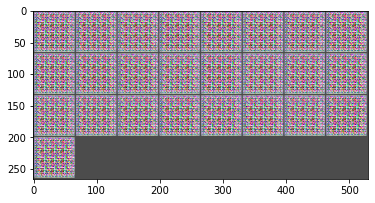

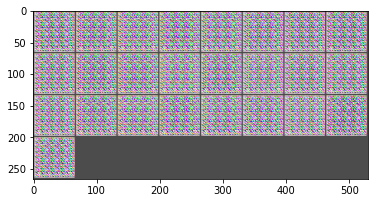

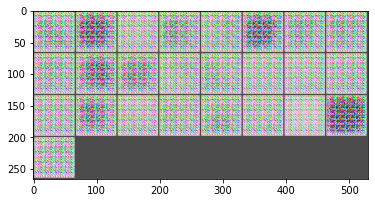

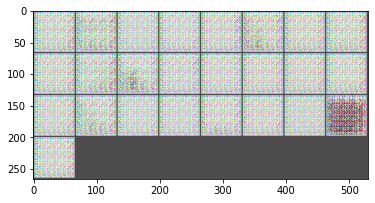

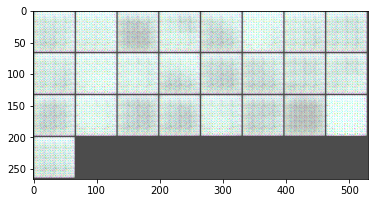

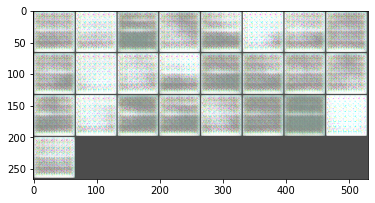

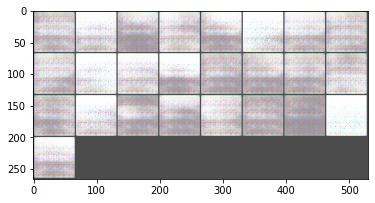

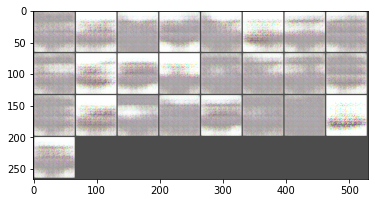

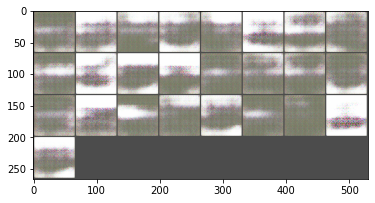

In [60]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

More training... (this time, using a smaller batch size)

In [ ]:
# Create a Dataloader for your own dataset
batch_size = 5

# pin_memory=True is helpful when working with tensors on the GPU
# See: https://sparrow.dev/pytorch-dataloader/
# Also: https://pytorch.org/docs/stable/data.html
your_train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

  0%|          | 0/155 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (134497676 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (151301008 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (94783876 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[1/10] - ptime: 274.03, loss_d: 1.395, loss_g: 1.856


  0%|          | 0/155 [00:00<?, ?it/s]

[2/10] - ptime: 268.41, loss_d: 1.314, loss_g: 1.688


  0%|          | 0/155 [00:00<?, ?it/s]

[3/10] - ptime: 265.94, loss_d: 1.062, loss_g: 2.416


  0%|          | 0/155 [00:00<?, ?it/s]

[4/10] - ptime: 265.72, loss_d: 0.873, loss_g: 3.083


  0%|          | 0/155 [00:00<?, ?it/s]

[5/10] - ptime: 273.30, loss_d: 0.808, loss_g: 3.416


  0%|          | 0/155 [00:00<?, ?it/s]

[6/10] - ptime: 271.48, loss_d: 0.777, loss_g: 3.438


  0%|          | 0/155 [00:00<?, ?it/s]

[7/10] - ptime: 269.29, loss_d: 0.684, loss_g: 3.536


  0%|          | 0/155 [00:00<?, ?it/s]

[8/10] - ptime: 269.47, loss_d: 0.710, loss_g: 3.699


  0%|          | 0/155 [00:00<?, ?it/s]

[9/10] - ptime: 273.06, loss_d: 0.691, loss_g: 3.745


  0%|          | 0/155 [00:00<?, ?it/s]

[10/10] - ptime: 273.88, loss_d: 0.666, loss_g: 3.583


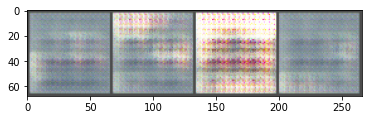

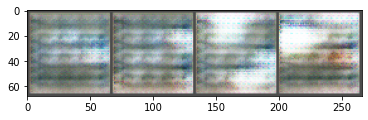

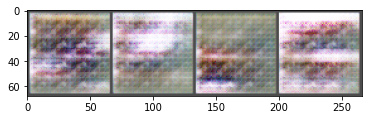

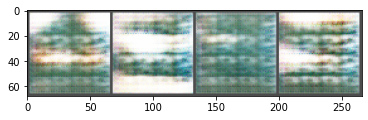

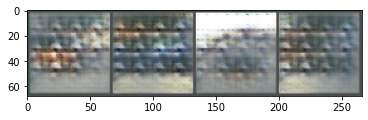

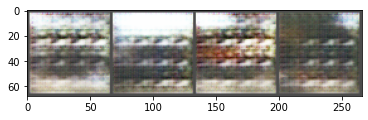

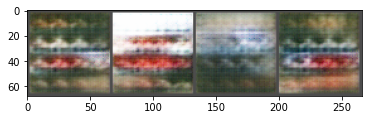

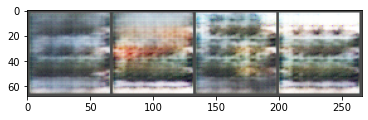

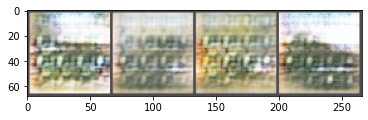

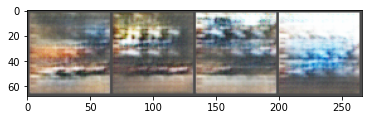

In [62]:
# Set learning rate
lr = 0.0002

# Set number of epochs to train for
train_epoch = 10

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
# Train GAN
collect_x_gen = []
train(your_train_loader)

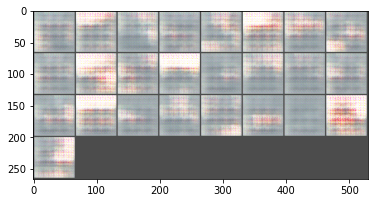

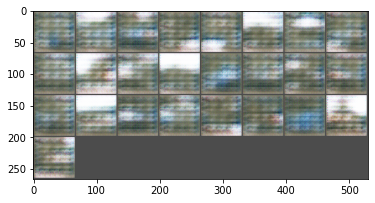

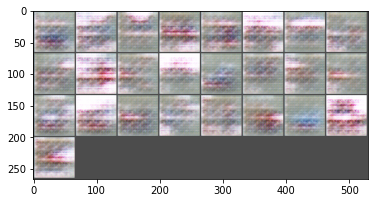

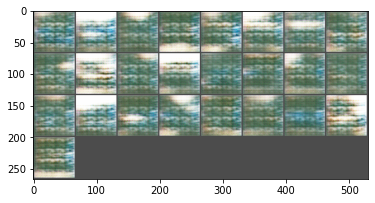

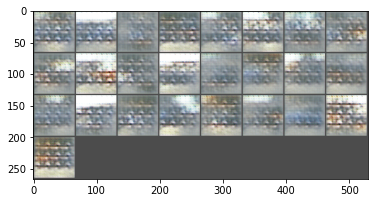

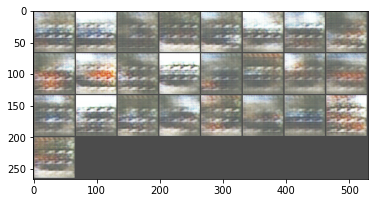

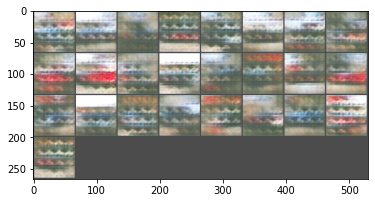

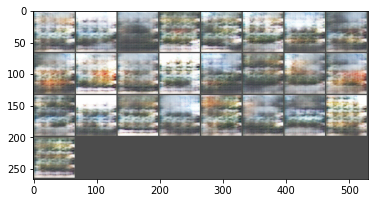

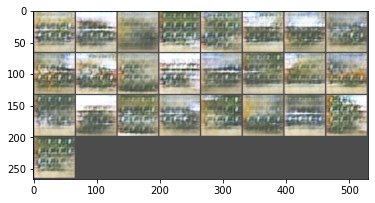

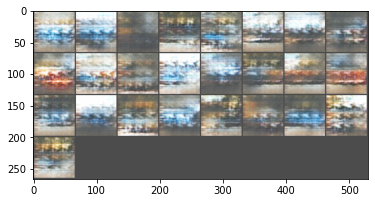

In [63]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

More training...


In [65]:
# Create a Dataloader for your own dataset
batch_size = 5

# pin_memory=True is helpful when working with tensors on the GPU
# See: https://sparrow.dev/pytorch-dataloader/
# Also: https://pytorch.org/docs/stable/data.html
your_train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

  0%|          | 0/155 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (134497676 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (94783876 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (151301008 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[1/10] - ptime: 275.56, loss_d: 0.597, loss_g: 4.568


  0%|          | 0/155 [00:00<?, ?it/s]

[2/10] - ptime: 271.71, loss_d: 0.643, loss_g: 4.279


  0%|          | 0/155 [00:00<?, ?it/s]

[3/10] - ptime: 273.46, loss_d: 0.551, loss_g: 4.702


  0%|          | 0/155 [00:00<?, ?it/s]

[4/10] - ptime: 275.92, loss_d: 0.599, loss_g: 4.443


  0%|          | 0/155 [00:00<?, ?it/s]

[5/10] - ptime: 274.52, loss_d: 0.559, loss_g: 4.572


  0%|          | 0/155 [00:00<?, ?it/s]

[6/10] - ptime: 275.36, loss_d: 0.445, loss_g: 4.679


  0%|          | 0/155 [00:00<?, ?it/s]

[7/10] - ptime: 276.86, loss_d: 0.476, loss_g: 5.077


  0%|          | 0/155 [00:00<?, ?it/s]

[8/10] - ptime: 277.21, loss_d: 0.539, loss_g: 4.312


  0%|          | 0/155 [00:00<?, ?it/s]

[9/10] - ptime: 279.02, loss_d: 0.454, loss_g: 4.927


  0%|          | 0/155 [00:00<?, ?it/s]

[10/10] - ptime: 276.93, loss_d: 0.419, loss_g: 4.796


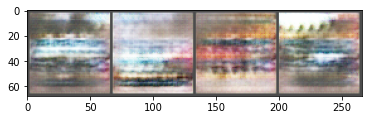

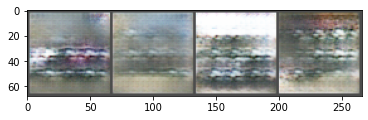

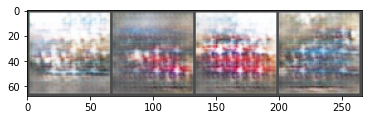

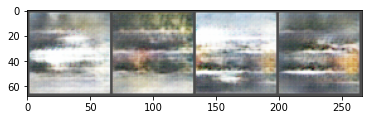

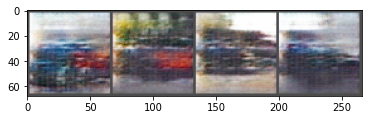

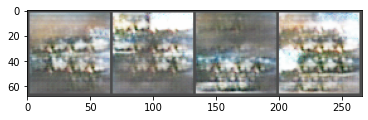

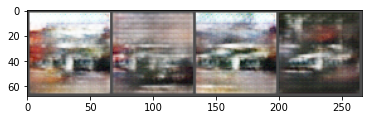

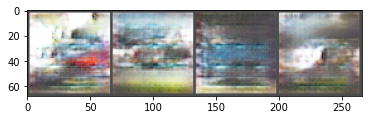

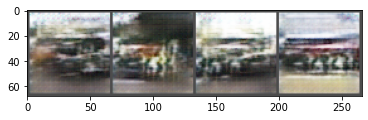

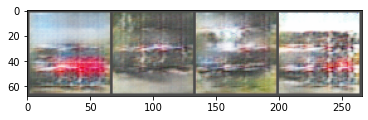

In [66]:
# Set learning rate
lr = 0.0002

# Set number of epochs to train for
train_epoch = 10

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
# Train GAN
collect_x_gen = []
train(your_train_loader)

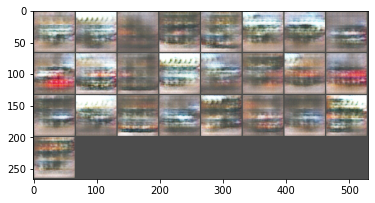

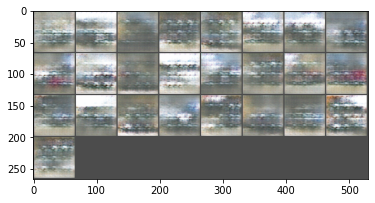

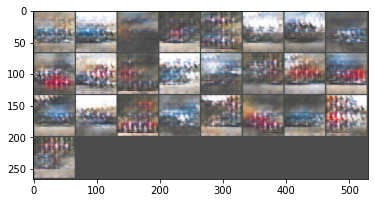

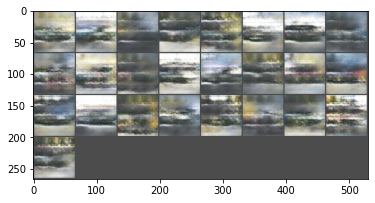

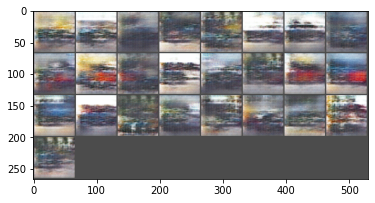

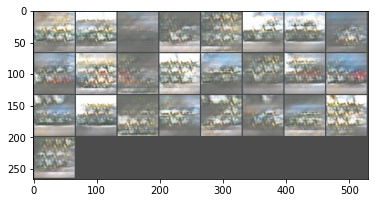

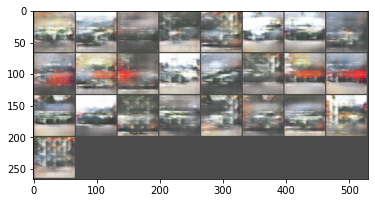

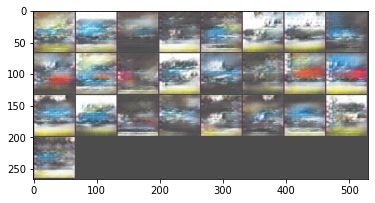

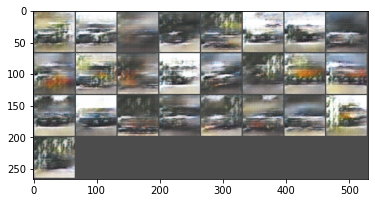

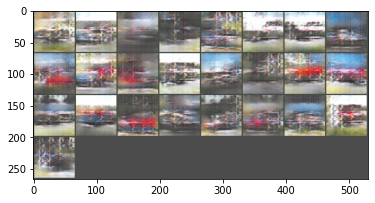

In [67]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

More training...


In [68]:
fixed_z_ = torch.randn((24, 100)).view(-1, 100, 1, 1)    # fixed noise
fixed_z_ = fixed_z_.to(device)

In [69]:
# Create a Dataloader for your own dataset
batch_size = 5

# pin_memory=True is helpful when working with tensors on the GPU
# See: https://sparrow.dev/pytorch-dataloader/
# Also: https://pytorch.org/docs/stable/data.html
your_train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
# Set learning rate
lr = 0.0002

# Set number of epochs to train for
train_epoch = 30

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
# Train GAN
collect_x_gen = []
train(your_train_loader)

  0%|          | 0/155 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (94783876 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (134497676 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (151301008 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[1/30] - ptime: 282.07, loss_d: 0.498, loss_g: 5.159


  0%|          | 0/155 [00:00<?, ?it/s]

[2/30] - ptime: 281.94, loss_d: 0.375, loss_g: 4.884


  0%|          | 0/155 [00:00<?, ?it/s]

[3/30] - ptime: 279.86, loss_d: 0.551, loss_g: 4.940


  0%|          | 0/155 [00:00<?, ?it/s]

[4/30] - ptime: 281.60, loss_d: 0.406, loss_g: 5.014


  0%|          | 0/155 [00:00<?, ?it/s]

[5/30] - ptime: 280.89, loss_d: 0.523, loss_g: 4.683


  0%|          | 0/155 [00:00<?, ?it/s]

[6/30] - ptime: 280.28, loss_d: 0.443, loss_g: 5.139


  0%|          | 0/155 [00:00<?, ?it/s]

[7/30] - ptime: 282.12, loss_d: 0.343, loss_g: 5.085


  0%|          | 0/155 [00:00<?, ?it/s]

[8/30] - ptime: 276.27, loss_d: 0.458, loss_g: 5.326


  0%|          | 0/155 [00:00<?, ?it/s]

[9/30] - ptime: 274.62, loss_d: 0.338, loss_g: 5.074


  0%|          | 0/155 [00:00<?, ?it/s]

In [1]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

NameError: ignored

# A demo of a state of the art GAN and "painting" with them in your browser:

https://gandissect.csail.mit.edu

By our colleagues at the MIT-IBM Watson AI Lab.


# Where to go from here
* Use a more exciting datasets - check out [the pytorch torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) to get started quickly.
* The [original GAN paper](https://papers.nips.cc/paper/5423-generative-adversarial-nets)
* The [DCGAN paper](https://arxiv.org/abs/1511.06434) which made it all work much better for images. Start from: pytorch DCGAN [example](https://github.com/pytorch/examples/blob/master/dcgan/main.py) and [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
* Newer generations of loss functions measure different distances between distributions $p_{data}$ and $p_G$. For example [WGAN](https://github.com/martinarjovsky/WassersteinGAN), [WGAN-GP](https://arxiv.org/abs/1704.00028), [Fisher GAN](https://arxiv.org/abs/1705.09675), [Sobolev GAN](https://arxiv.org/abs/1711.04894), many more. They often have better stability properties wrt the original GAN loss.

# References for this tutorial
* pytorch DCGAN [example](https://github.com/pytorch/examples/blob/master/dcgan/main.py) and [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) by Nathan Inkawhich
* [Medium blog post](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f) by Diego Gomez Mosquera
* [Material made for ITDS course at CUNY](https://github.com/grantmlong/itds2019/blob/master/lecture-6/DL_lab_solutions.ipynb) by Tom Sercu (that's me!)
* [Blog post](https://towardsdatascience.com/graduating-in-gans-going-from-understanding-generative-adversarial-networks-to-running-your-own-39804c283399) by Cecelia Shao
* [GAN overview image](https://www.slideshare.net/xavigiro/deep-learning-for-computer-vision-generative-models-and-adversarial-training-upc-2016) from Xavier Giro